Detailed documentation of this notebook can be found here: https://github.com/junyoung-sim/gbm

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from download import download

np.set_printoptions(suppress=True)

In [2]:
OBS = 100 # observation period
EXT = 20 # extrapolation period
EPOCH = 1000 # number of simulations

In [3]:
ticker = input("Ticker: ")
apikey = open("apikey", "r").readline()
raw = download(ticker, apikey)
print(raw)

Ticker: IEF
            date   adjClose
0     2002-07-26  47.590198
1     2002-07-29  47.032612
2     2002-07-30  44.953426
3     2002-07-31  45.365704
4     2002-08-01  45.552658
...          ...        ...
5299  2023-08-15  93.800000
5300  2023-08-16  93.440000
5301  2023-08-17  93.320000
5302  2023-08-18  93.600000
5303  2023-08-21  92.970000

[5304 rows x 2 columns]


IEF P&L
                 0
count  5303.000000
mean      0.000136
std       0.004361
min      -0.044207
25%      -0.002424
50%       0.000238
75%       0.002653
max       0.034263


[Text(0.5, 0, 'IEF P&L'), Text(0, 0.5, 'Frequency')]

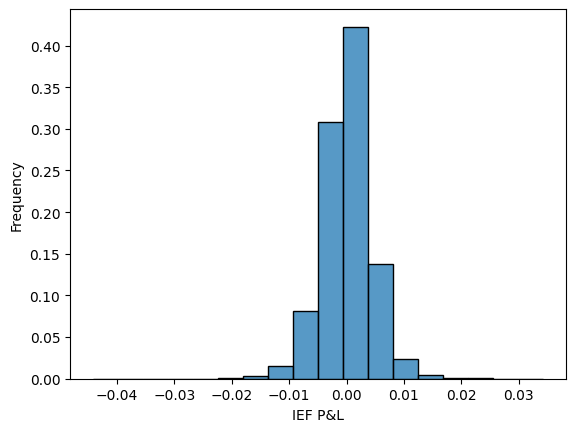

In [4]:
t0 = np.array(raw["adjClose"][0:-1])
t1 = np.array(raw["adjClose"][1:])
returns = (t1 - t0) / t0

returns = np.array(returns)
raw = raw.iloc[1:]

print("{} P&L" .format(ticker))
print(pd.DataFrame(returns).describe())

ax = sns.histplot(data=returns, binwidth=np.std(returns), stat="probability")
ax.set(xlabel="{} P&L" .format(ticker), ylabel="Frequency")

In [5]:
valuation_series = []
recent_simulations = []

In [6]:
for T in range(OBS-1, raw.shape[0]):
    s0 = raw["adjClose"][T] # current value
    mu = returns[T+1-OBS:T+1].mean() # mean daily return
    sigma = np.std(returns[T+1-OBS:T+1]) # variability in daily returns
    drift = mu + 0.5 * sigma**2 # drift of random walk
    
    brownian = np.random.normal(0, 1, (EPOCH, EXT)) # brownian shock values
    brownian = np.cumsum(brownian, axis=1)
    
    t = np.arange(1, EXT+1) # extrapolation time
    path = s0 * np.exp(drift * t + sigma * brownian) # simulated paths
    
    # P(s_t > s0 | t E {1, 2, 3, ... , EXT}) (valuation score)
    score = float(sum(path.flatten() > s0)) / (EPOCH * EXT)
    valuation_series.append(score)
    
    if T == raw.shape[0] - 1: # save recent simulations
        recent_simulations = np.insert(path, 0, s0, axis=1)
    
    #print("T={} @ {} VAL={}" .format(T, ticker, score))

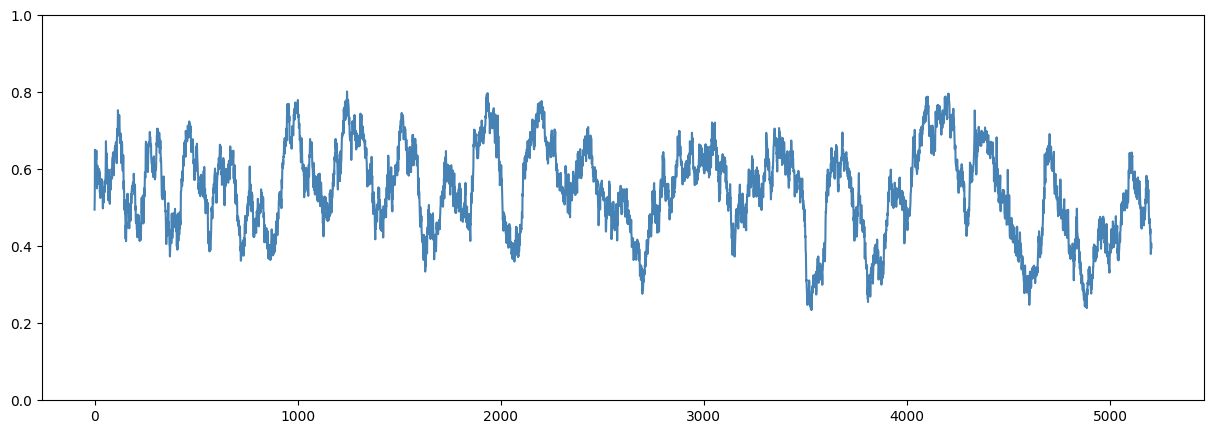

In [7]:
plt.figure(figsize=(15,5))
plt.plot(valuation_series, color="steelblue", label="valuation")
plt.ylim(0, 1)
plt.show()

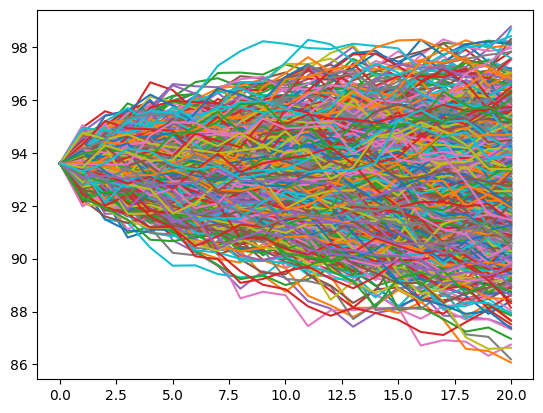

In [8]:
for path in recent_simulations:
    plt.plot(path)
plt.show()